# 0. Imports and Toy Dataset Creation

In [20]:
import math
import networkx as nx
import torch
from collections import deque
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import (
    adjusted_mutual_info_score as AMI,
    adjusted_rand_score as ARI,
)

In [21]:
import numpy as np
np.random.seed(42)

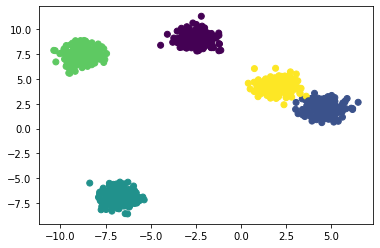

In [22]:
X, y, centroids_true = make_blobs(
    n_samples=1000,
    centers=5,
    cluster_std=0.6,
    return_centers=True
)
plt.scatter(X[:,0], X[:,1], c=y);

# 1. Naive Implementation

In [23]:
class DBSCAN:
    def __init__(self, eps, minPts):
        self._eps = eps
        self._minPts = minPts

    def fit(self, X):
        self._construct_graph(X)
        self._get_clusters()
        self._get_centroids(X)
        self._cluster_outliers(X)

    def score(self, X, y):
        y_pred = self.predict(X)
        return (AMI(y, y_pred), ARI(y, y_pred))

    def predict(self, X):
        y = []
        for x in X:
            distances = {
                label: self._distance(x, centroid)
                for label, centroid in self._centroids.items()
            }
            y.append(min(distances, key=distances.get))
        return y

    def _construct_graph(self, X):
        cardinality = len(X)
        graph = nx.Graph()
        graph.add_nodes_from(
            list(range(cardinality)), is_core=False, visited=False, cluster=None
        )
        for i in range(cardinality):
            for j in range(i + 1, cardinality):
                if self._distance(X[i], X[j]) < self._eps:
                    graph.add_edge(i, j)
            if graph.degree[i] >= self._minPts:
                graph.nodes[i]["is_core"] = True
        self._graph = graph

    def _get_clusters(self):
        cluster_label = 0
        for node in self._graph:
            if not self._graph.nodes[node]["visited"] and self._graph.nodes[node][
                "is_core"
            ]:
                self._graph.nodes[node]["visited"] = True
                self._graph.nodes[node]["cluster"] = cluster_label
                self._bfs_node(node, cluster_label)
                cluster_label += 1
        self._num_clusters = cluster_label

    def _bfs_node(self, source, cluster_label):
        neighbors = self._graph.neighbors
        queue = deque([(source, len(self._graph), neighbors(source))])
        while queue:
            _, depth_now, children = queue[0]
            try:
                child = next(children)
                if not self._graph.nodes[child]["visited"]:
                    self._graph.nodes[child]["visited"] = True
                    self._graph.nodes[child]["cluster"] = cluster_label
                    if depth_now > 1:
                        queue.append((child, depth_now - 1, neighbors(child)))
            except StopIteration:
                queue.popleft()

    def _get_centroids(self, X):
        self._centroids = {}
        for i in range(self._num_clusters):
            X_list = []
            for node in self._graph:
                if self._graph.nodes[node]["cluster"] == i:
                    X_list.append(X[i])
            self._centroids.update({i: np.mean(X_list, axis=0)})

    def _cluster_outliers(self, X):
        for node in self._graph:
            if self._graph.nodes[node]["cluster"] is None:
                self._graph.nodes[node]["cluster"] = self.predict(X[node])

    @staticmethod
    def _distance(p1, p2):
        return np.linalg.norm(p1 - p2)


AMI: 0.5165726952659874, ARI: 0.31735800955175525


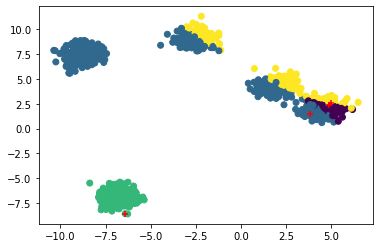

In [24]:
clusterer = DBSCAN(1, 2*X.shape[1])
clusterer.fit(X)
ami, ari = clusterer.score(X, y)
print(f'AMI: {ami}, ARI: {ari}')
y_pred = clusterer.predict(X)
best_centroids = np.array(
    [centroid for centroid in clusterer._centroids.values()]
)
plt.scatter(X[:,0], X[:,1], c=y_pred);
plt.scatter(best_centroids[:,0], best_centroids[:,1], marker='+', color='red');

# 2. Vectorized Implementation

# 3. GPU Accelerated Implementation